# About the notebook

load python libraries

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_context('notebook', font_scale=1.5)
%matplotlib inline
%load_ext rpy2.ipython

load R libraries

In [2]:
%%R
library(tidyverse)
library(MPSK)
library(tsne)
library(pheatmap)
library(RColorBrewer)
library(flowCore)
library(flowStats)
library(flowViz)
library(flowMatch)

/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘flowCore’


  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packag

# Import data

mpsk results

In [3]:
!ls "/data/SMPK"

C.npy  markers.txt  res0_GEN070XT_CMVpp65.pic  Y_raw.npy


In [4]:
target_dir = "/data/SMPK"

with open(os.path.join(target_dir, "res0_GEN070XT_CMVpp65.pic"), 'rb') as f:
    res = pickle.load(f)

markers

In [5]:
markers = [line.strip() for line in open(os.path.join(target_dir, 'markers.txt'))]
markers_label = list(map(lambda x: x.split()[0], markers))

passed into R environment

In [6]:
type(res)

rpy2.robjects.vectors.ListVector

In [7]:
%%R -i res
names(res)

[1] "chain" "data"  "prior" "pmc"  


In [8]:
%%R -i markers,markers_label
markers = unlist(markers)
print(markers)
cat("==========================\n")
markers_label = unlist(markers_label)
print(markers_label)

 [1] "FSC-A"                "SSC-A"                "Aqua Amine FLR-A"    
 [4] "CD3 APC-H7 FLR-A"     "CD4 PE-Cy7 FLR-A"     "CD8 PerCP-Cy55 FLR-A"
 [7] "TNFa FITC FLR-A"      "IL2 BV421 FLR-A"      "IFNg APC FLR-A"      
[10] "CD107a PE FLR-A"     
 [1] "FSC-A"  "SSC-A"  "Aqua"   "CD3"    "CD4"    "CD8"    "TNFa"   "IL2"   
 [9] "IFNg"   "CD107a"


process the MPSK results

In [9]:
%%R
resRelab      = relabelChain(res)
resCalibrated = calibrate(resRelab)
chainSummary  = summarizeChain(resRelab)

In [10]:
%%R
print(names(res))
print("=====================")
print(names(resRelab))
print("=====================")
print(names(resCalibrated))
print("=====================")
print(names(chainSummary))

[1] "chain" "data"  "prior" "pmc"  
[1] "====================="
[1] "chain" "data"  "prior" "pmc"  
[1] "====================="
[1] "Y_cal"                    "calibration_distribution"
[3] "calibration_median"      
[1] "====================="
 [1] "xi0"      "psi"      "alpha"    "W"        "xi"       "Omega"   
 [7] "Sigma"    "E"        "meanvec"  "meanvec0" "t"        "S"       
[13] "varphi"   "a0"      


Get the cluster label assigned by MPSK

In [11]:
%%R
print(names(resRelab$data))

print(length(chainSummary$t))
print(head(chainSummary$t))
print(unique(chainSummary$t))

[1] "Y" "C"
[1] 180000
[1] 4 3 1 4 8 1
[1]  4  3  1  8  9  2 10  6  7


store the results

In [12]:
%%R
saveRDS(res,           "/data/clintko/SMPK/ep8cs_mpsk_raw.RDS")
saveRDS(resRelab,      "/data/clintko/SMPK/ep8cs_mpsk_relab.RDS")
saveRDS(resCalibrated, "/data/clintko/SMPK/ep8cs_mpsk_cal.RDS")
saveRDS(chainSummary,  "/data/clintko/SMPK/ep8cs_mpsk_chainSummary.RDS")

# get the subset

In [97]:
%%R
### extract needed data
clust = chainSummary$t
C     = resRelab$data$C
Y     = resRelab$data$Y
Y_cal = resCalibrated$Y_cal

### assign column names
colnames(Y)     = markers_label
colnames(Y_cal) = paste(markers_label, "Cal")

### raw and calibrated data
dat_mpsk = cbind(C, clust, Y) %>% as.data.frame
colnames(dat_mpsk)[1:2] = c("sample", "cluster")

dat_mpsk_cal = cbind(C, clust, Y_cal) %>% as.data.frame
colnames(dat_mpsk_cal)[1:2] = c("sample", "cluster")

### get 1000 events for each sample
df = data.frame(idx = 1:nrow(Y), sample = C) %>% 
    group_by(sample) %>% 
    sample_frac(0.1) %>% 
    as.data.frame

dat_mpsk     = dat_mpsk[    df$idx, ]
dat_mpsk_cal = dat_mpsk_cal[df$idx, ]

### output
print(length(clust))
print(length(C))
print(dim(Y))
print(dim(Y_cal))
print(dim(dat_mpsk))

cat("\n===========================")
print(table(dat_mpsk$sample))
print(table(dat_mpsk_cal$sample))

cat("\n===========================\n")
print(colnames(dat_mpsk))

[1] 180000
[1] 180000
[1] 180000     10
[1] 180000     10
[1] 18000    12

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 
  17   18 
1000 1000 

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 
  17   18 
1000 1000 

 [1] "sample"  "cluster" "FSC-A"   "SSC-A"   "Aqua"    "CD3"     "CD4"    
 [8] "CD8"     "TNFa"    "IL2"     "IFNg"    "CD107a" 


# Observe the MPSK cluster labels

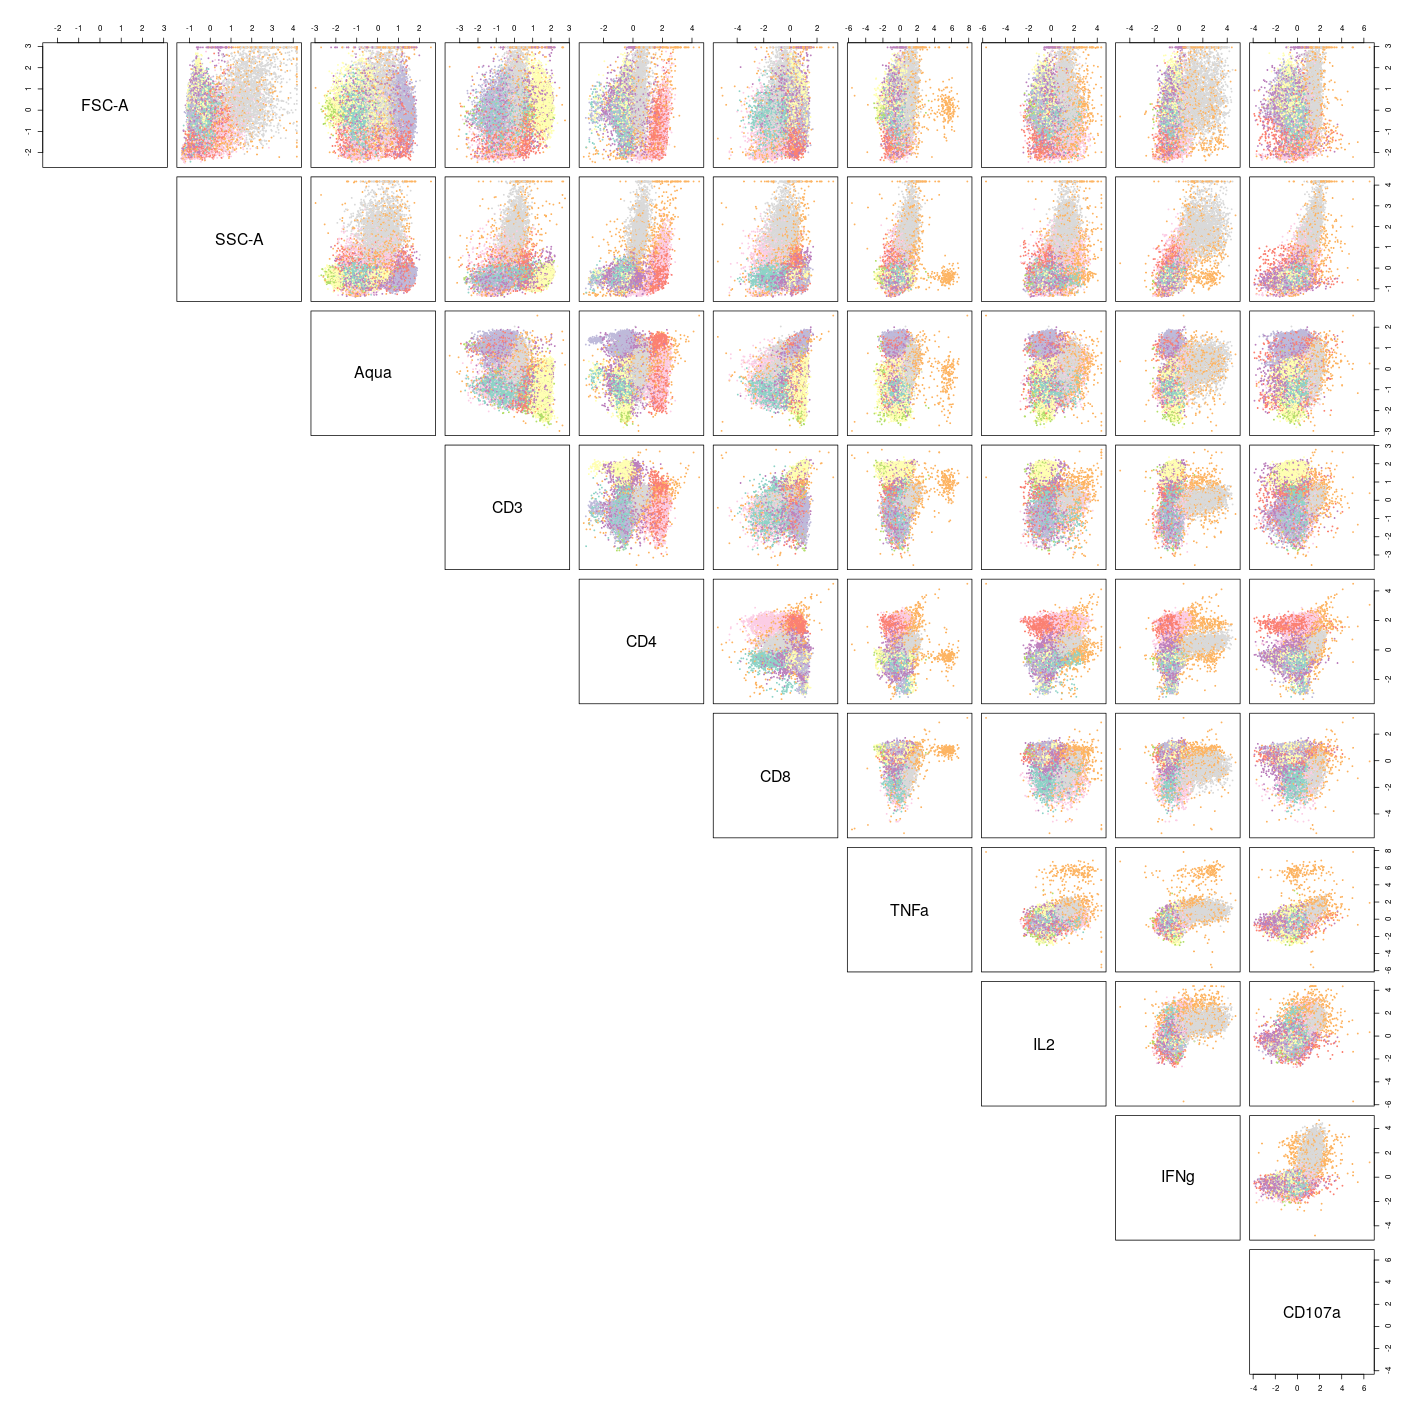

In [98]:
%%R -w 50 -h 50 -u cm
my_cols = brewer.pal(10, "Set3")
dat = dat_mpsk

pairs(dat[, -c(1, 2)], pch = 20,  cex = 0.5,
      col = my_cols[dat$cluster],
      lower.panel = NULL)

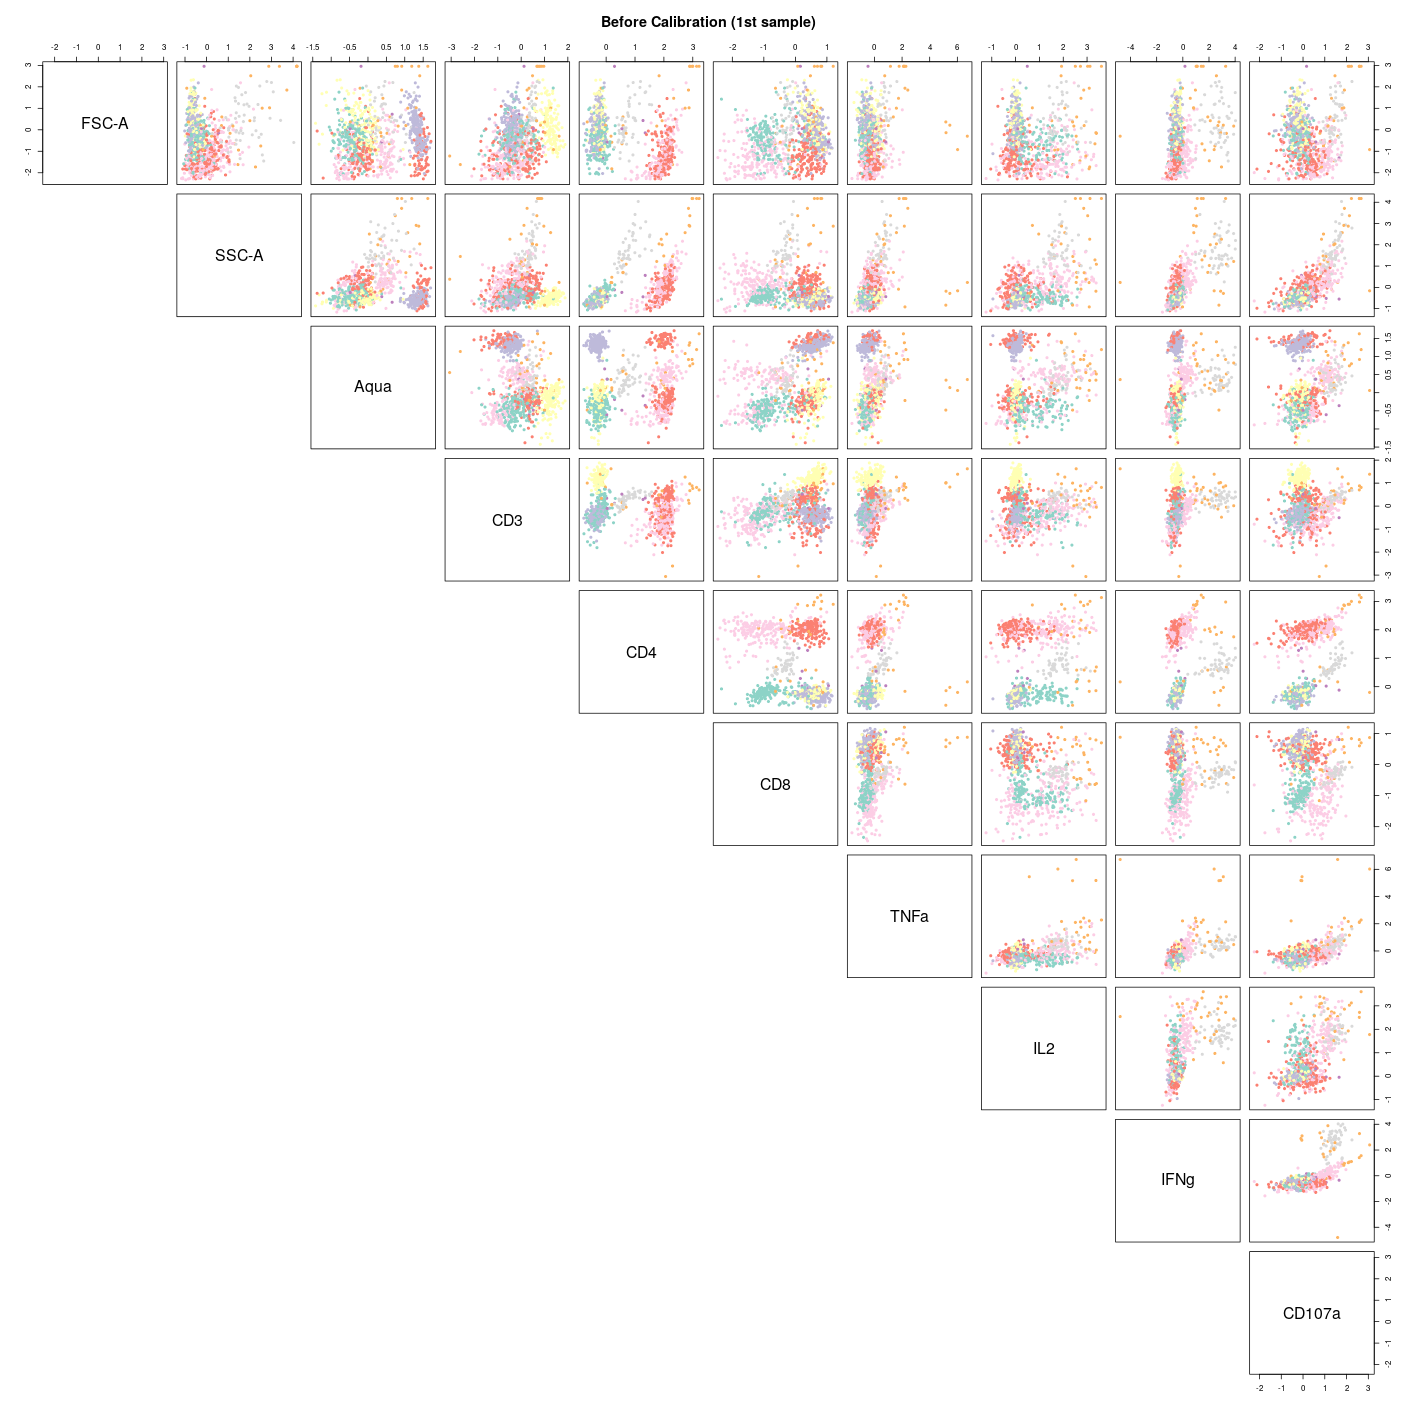

In [99]:
%%R -w 50 -h 50 -u cm
my_cols = brewer.pal(10, "Set3")
dat = dat_mpsk %>% dplyr::filter(sample == 1)

pairs(dat[, -c(1, 2)], pch = 20,  cex = 1.0,
      col = my_cols[dat$cluster],
      lower.panel = NULL,
      main = "Before Calibration (1st sample)")

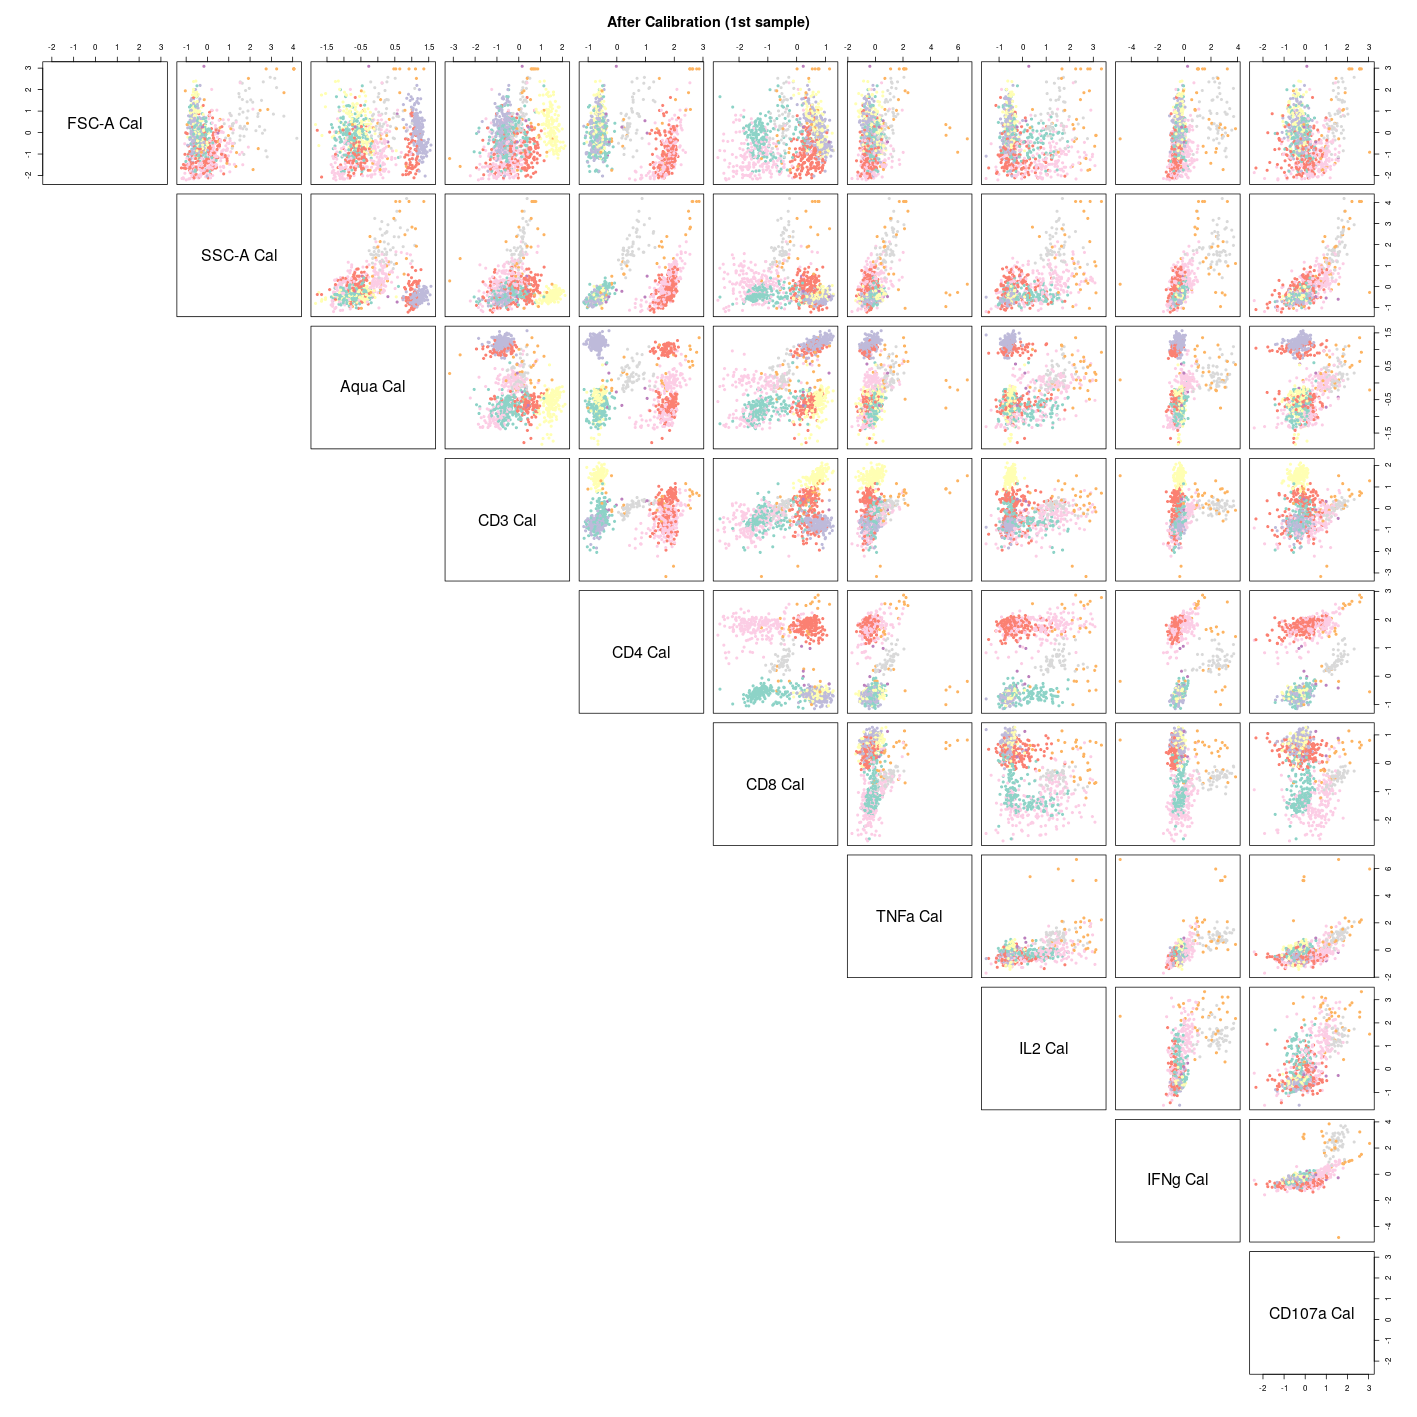

In [100]:
%%R -w 50 -h 50 -u cm
my_cols = brewer.pal(10, "Set3")
dat = dat_mpsk_cal %>% dplyr::filter(sample == 1)

pairs(dat[, -c(1, 2)], pch = 20,  cex = 1.0,
      col = my_cols[dat$cluster],
      lower.panel = NULL,
      main = "After Calibration (1st sample)")

# Evaluate how well is the clustering in MPSK

In [123]:
%%R
clust = dat$cluster %>% as.integer
clust %>% unique %>% sort %>% print

clust[clust==10] = 5L
clust[clust==9]  = 7L
clust %>% unique %>% sort %>% print

[1]  1  2  3  4  6  8  9 10
[1] 1 2 3 4 5 6 7 8


In [101]:
%%R
dat = dat_mpsk %>% dplyr::filter(sample == 1) 

mat   = dat %>% dplyr::select(-sample, -cluster)
clust = dat$cluster %>% as.integer
clust[clust==10] = 5L
clust[clust==9]  = 7L

mat   %>% head   %>% print
mat   %>% dim    %>% print
mat   %>% class  %>% print
clust %>% head   %>% print
clust %>% length %>% print
clust %>% class  %>% print
clust %>% unique %>% sort  %>% print

clustSample1 = ClusteredSample(
    labels = clust, 
    sample = mat)

        FSC-A      SSC-A        Aqua        CD3        CD4        CD8
1 -1.12139029 -0.8081419 -0.34619545 -1.2383215  1.9299857 -1.0288988
2  0.42727092 -0.5726850 -0.06027771  1.1252251 -0.2964647  0.4093849
3  0.09139997 -0.4589549 -0.26412620 -0.4671530 -0.3258575 -1.3330838
4 -1.34431446  0.6108584 -0.16751269  0.3649277  2.2324985  0.7785573
5 -0.45504485 -0.5683518 -0.29577769 -1.1035488 -0.1939440 -0.8524219
6 -0.65292379  1.2892204  0.58128259  0.1560728  0.5493051 -0.6410095
         TNFa         IL2       IFNg     CD107a
1 -0.83947590 -0.31083587 -0.8841784 -0.8182951
2 -0.91287865  0.04225989 -0.5129979 -0.3057650
3 -0.43575955  2.07822968 -0.6712615 -0.3442771
4 -0.05096929 -0.39460708 -0.3378030  0.2530759
5 -0.35285199  0.95267100 -0.6270216 -0.3984208
6 -0.10846958  3.33156338  1.4651495  0.9648906
[1] 1000   10
[1] "data.frame"
[1] 8 2 1 4 1 6
[1] 1000
[1] "integer"
[1] 1 2 3 4 5 6 7 8


In [102]:
%%R
tmp = dat_mpsk
tmp$cluster = as.integer(tmp$cluster)
tmp$cluster[tmp$cluster==10] = 5L
tmp$cluster[tmp$cluster==9]  = 7L

dat   = tmp %>% dplyr::filter(sample == 1) 
mat   = dat %>% dplyr::select(-sample, -cluster)
clust = dat$cluster
clustSample1 = ClusteredSample(labels = clust, sample = mat)

dat   = tmp %>% dplyr::filter(sample == 2) 
mat   = dat %>% dplyr::select(-sample, -cluster)
clust = dat$cluster
clustSample2 = ClusteredSample(labels = clust, sample = mat)

In [103]:
%%R
mec = match.clusters(
    clustSample1, 
    clustSample2,
    dist.type="Mahalanobis", 
    unmatch.penalty=99999)

summary(mec)

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            1
           2                            2
           3                            3
           4                            4
           5                            5
           6                            6
           7                            7
           8                            8


In [120]:
%%R
dat = dat_mpsk
dat$cluster = as.integer(dat$cluster)
dat$cluster[dat$cluster==10] = 5L
dat$cluster[dat$cluster==9]  = 7L

dat_sub  = dat %>% dplyr::filter(sample == 1) 
mat      = dat_sub %>% dplyr::select(-sample, -cluster)
clust    = dat_sub$cluster
clustRef = ClusteredSample(labels = clust, sample = mat)

lst_mec = lapply(2:18, function(idx){
    dat_sub  = dat %>% dplyr::filter(sample == idx) 
    mat      = dat_sub %>% dplyr::select(-sample, -cluster)
    clust    = dat_sub$cluster
    clustSample = ClusteredSample(labels = clust, sample = mat)
    
    mec = match.clusters(
    clustRef, 
    clustSample,
    dist.type="Mahalanobis", 
    unmatch.penalty=99999)
 
    return(mec)
})

res = lapply(lst_mec, function(x){x@match21 %>% unlist})
res = do.call(rbind, res)
res = rbind(1:8, res)
rownames(res) = paste("Sample", 1:18)
res

          [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
Sample 1     1    2    3    4    5    6    7    8
Sample 2     1    2    3    4    5    6    7    8
Sample 3     1    2    3    4    5    6    7    8
Sample 4     1    2    3    4    5    6    7    8
Sample 5     1    2    3    4    5    6    7    8
Sample 6     1    2    3    4    5    6    7    8
Sample 7     1    2    3    4    5    6    7    8
Sample 8     6    2    3    5    4    1    7    8
Sample 9     1    2    3    4    5    6    7    8
Sample 10    1    2    3    4    5    6    7    8
Sample 11    1    2    3    4    6    7    5    8
Sample 12    1    2    3    4    5    6    7    8
Sample 13    1    2    3    4    5    6    7    8
Sample 14    1    2    3    4    5    6    7    8
Sample 15    1    2    3    4    5    6    7    8
Sample 16    1    2    3    4    5    6    7    8
Sample 17    1    2    3    4    5    6    7    8
Sample 18    1    2    3    4    5    6    7    8


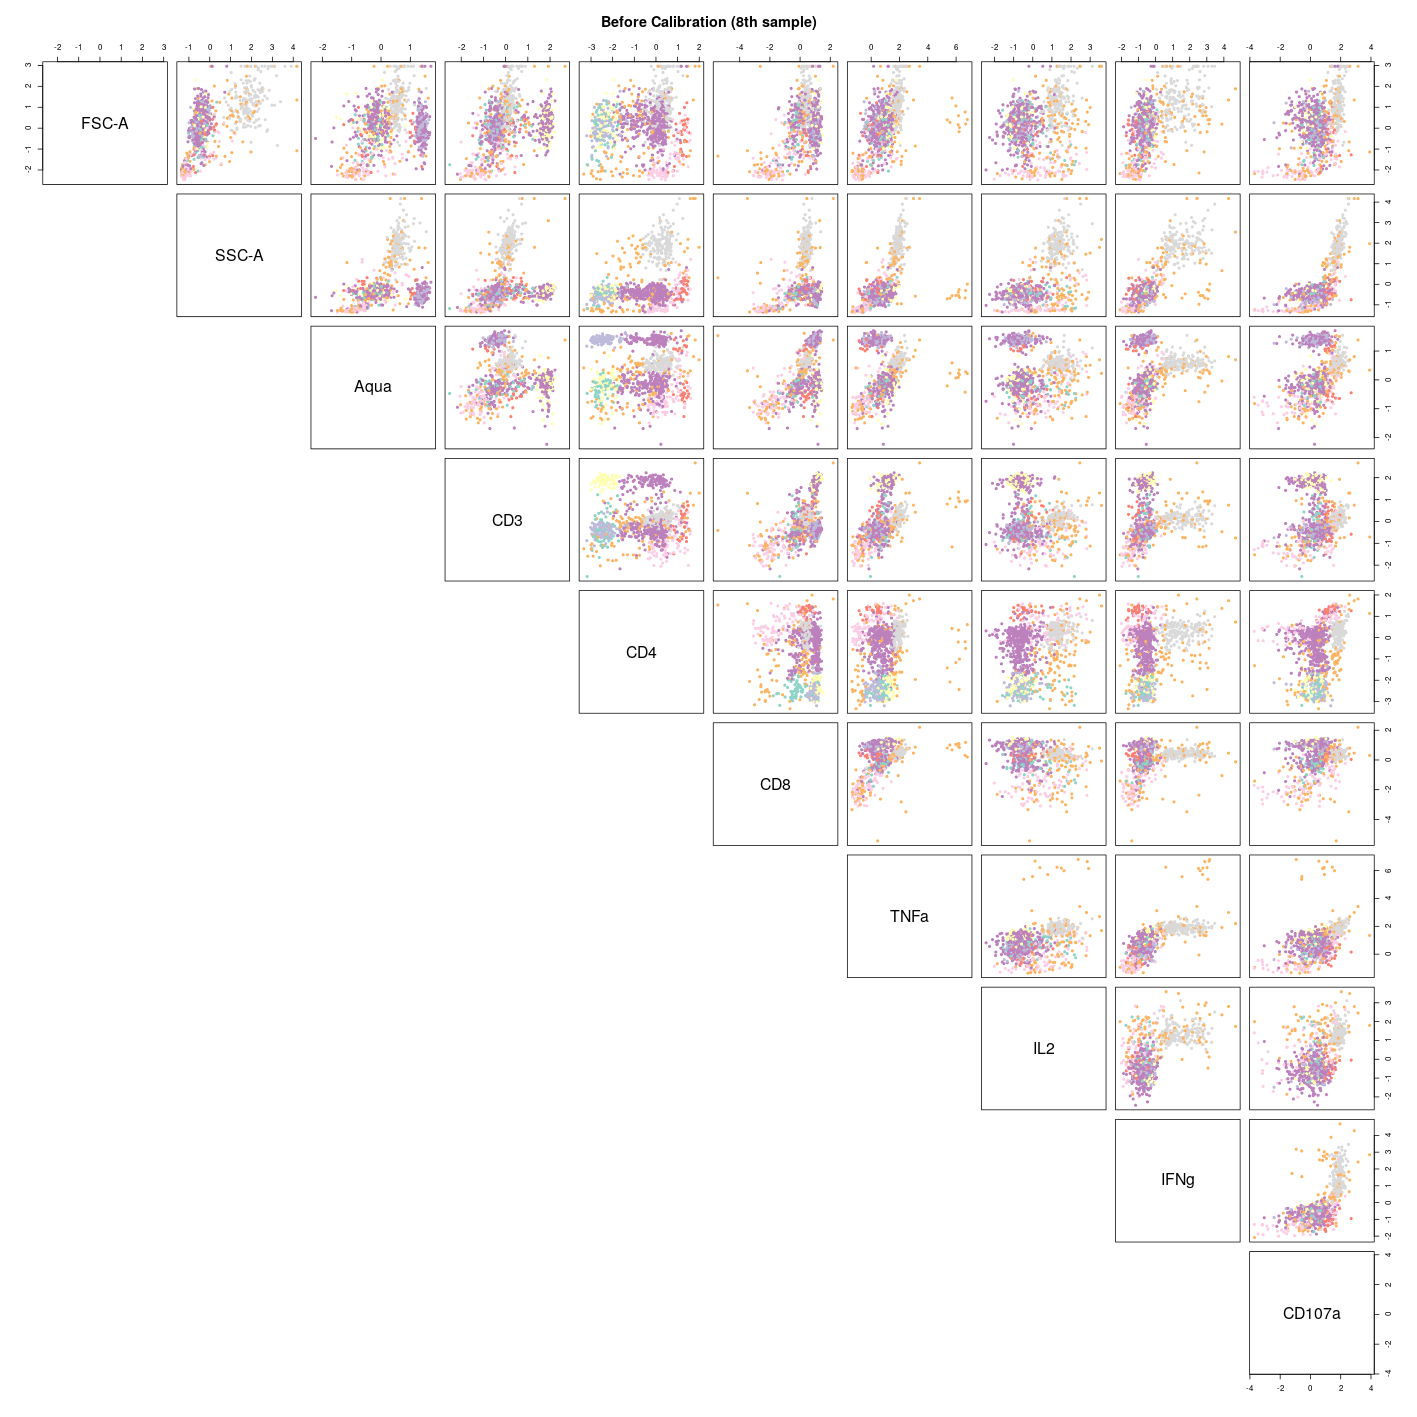

In [125]:
%%R -w 50 -h 50 -u cm
my_cols = brewer.pal(10, "Set3")
dat = dat_mpsk %>% dplyr::filter(sample == 8)

pairs(dat[, -c(1, 2)], pch = 20,  cex = 1.0,
      col = my_cols[dat$cluster],
      lower.panel = NULL,
      main = "Before Calibration (8th sample)")

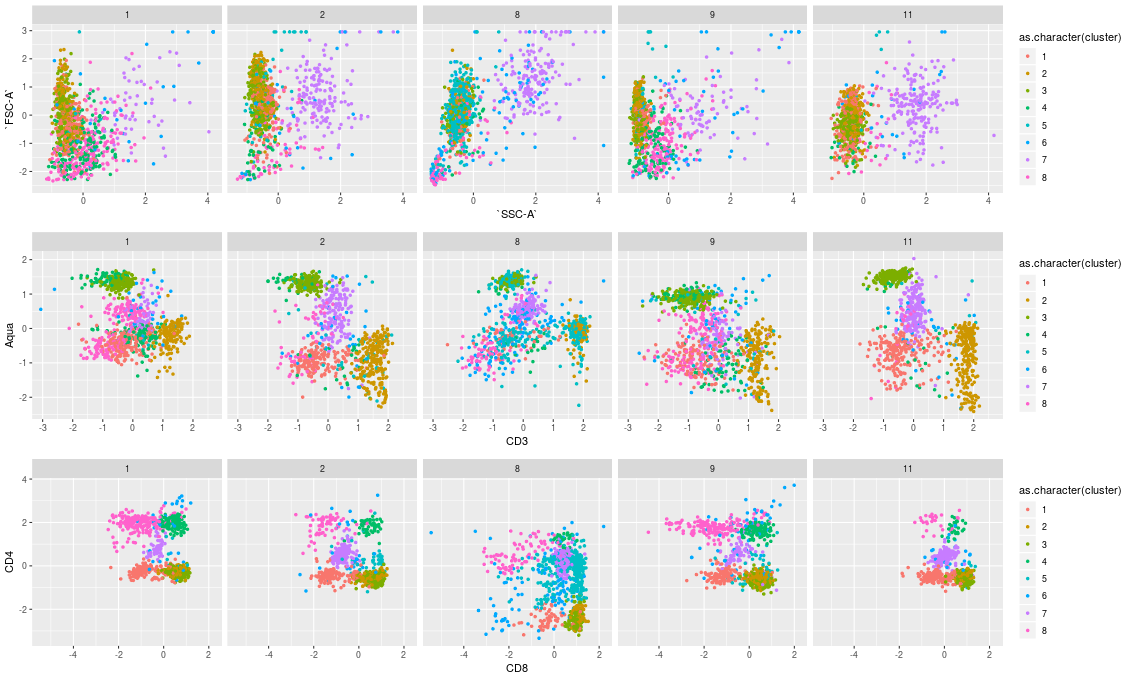

In [171]:
%%R -w 40 -h 24 -u cm
my_cols = brewer.pal(10, "Set3")

dat = dat_mpsk
dat$cluster = as.integer(dat$cluster)
dat$cluster[dat$cluster==10] = 5L
dat$cluster[dat$cluster==9]  = 7L
dat = dat %>% dplyr::filter(sample %in% c(1, 2, 8, 9, 11))

gp1 = dat %>% ggplot(., aes(x = `SSC-A`, y = `FSC-A`, color = as.character(cluster))) + 
          geom_point(size = 1) + 
          facet_wrap(~sample, nrow = 1)
gp2 = dat %>% ggplot(., aes(x = CD3, y = Aqua, color = as.character(cluster))) + 
          geom_point(size = 1) + 
          facet_wrap(~sample, nrow = 1)

gp3 = dat %>% ggplot(., aes(x = CD8, y = CD4, color = as.character(cluster))) + 
          geom_point(size = 1) + 
          facet_wrap(~sample, nrow = 1)


gridExtra::grid.arrange(gp1, gp2, gp3)

check

In [129]:
%%R
dat = dat_mpsk
dat$cluster = as.integer(dat$cluster)
dat$cluster[dat$cluster==10] = 5L
dat$cluster[dat$cluster==9]  = 7L

dat %>% dplyr::filter(sample == 1) %>% .$cluster %>% unique %>% sort %>% print
dat %>% dplyr::filter(sample == 8) %>% .$cluster %>% unique %>% sort %>% print

[1] 1 2 3 4 5 6 7 8
[1] 1 2 3 4 5 6 7 8


# Evaluate how well is the calibration in MPSK

In [104]:
%%R
print(head(dat, 3))

print("======================")
print(head(mat, 3))

print("======================")
df_annot_row = data.frame(cluster = dat$cluster)
rownames(df_annot_row) = rownames(dat)
print(head(df_annot_row))

print("======================")
print(dim(mat))
print(dim(df_annot_row))

print("======================")
rownames(mat) %>% head %>% print
rownames(df_annot_row) %>% head %>% print

  sample cluster      FSC-A      SSC-A       Aqua        CD3        CD4
1      2       3 -0.8559431 -0.4363087  1.5022739 -0.3864878 -0.4433505
2      2       2  0.7192543 -0.5603549 -0.6203606  1.4437010 -0.3576931
3      2       8 -1.1389970 -0.3839802 -0.9659468 -0.7247639  1.8601117
         CD8       TNFa        IL2        IFNg     CD107a
1  0.8808878 -0.3598396 -0.2540106 -0.06213348 -0.2417348
2  0.6444953  0.5359640 -0.5533862 -0.20970404 -0.8316488
3 -2.1422265 -0.9143391 -0.6244365 -1.22050396 -0.5942484
[1] "======================"
       FSC-A      SSC-A       Aqua        CD3        CD4        CD8       TNFa
1 -0.8559431 -0.4363087  1.5022739 -0.3864878 -0.4433505  0.8808878 -0.3598396
2  0.7192543 -0.5603549 -0.6203606  1.4437010 -0.3576931  0.6444953  0.5359640
3 -1.1389970 -0.3839802 -0.9659468 -0.7247639  1.8601117 -2.1422265 -0.9143391
         IL2        IFNg     CD107a
1 -0.2540106 -0.06213348 -0.2417348
2 -0.5533862 -0.20970404 -0.8316488
3 -0.6244365 -1.22050396 -0

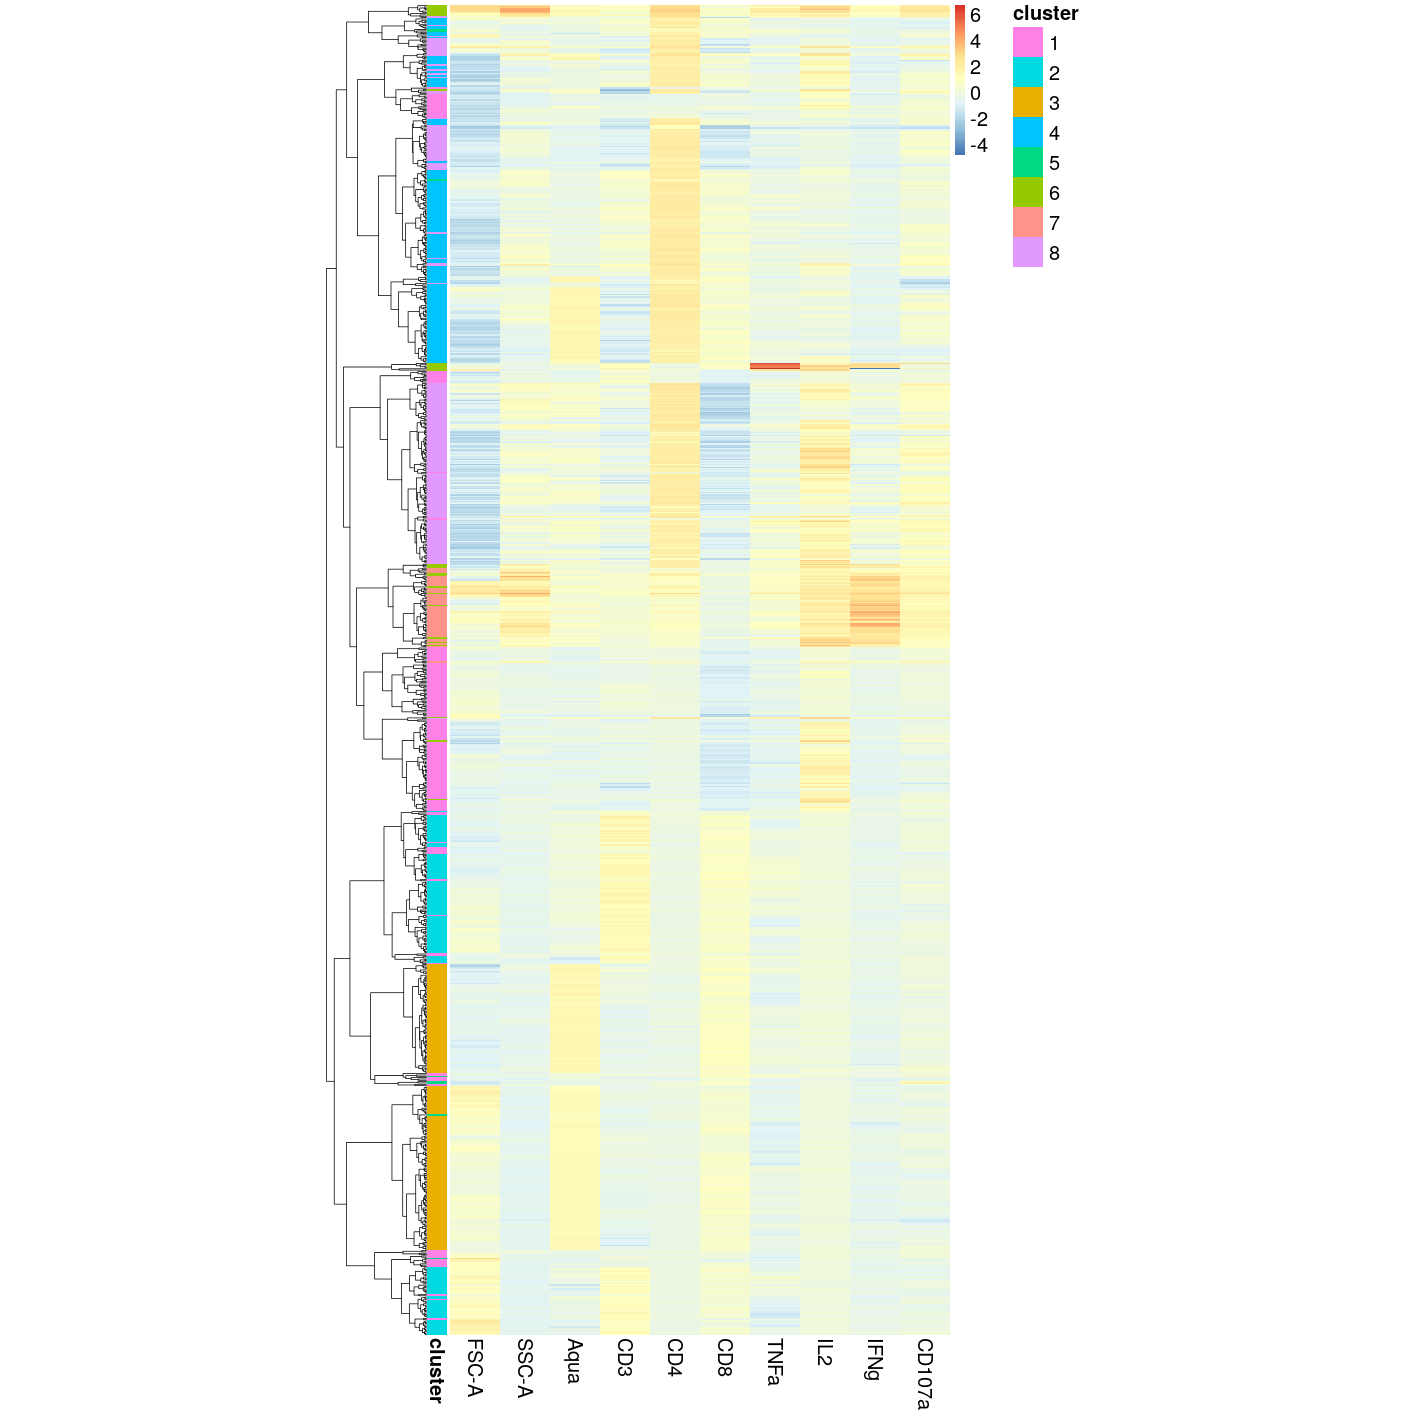

In [105]:
%%R -w 50 -h 50 -u cm
dat = dat_mpsk
dat$cluster = as.integer(dat$cluster)
dat$cluster[dat$cluster==10] = 5L
dat$cluster[dat$cluster==9 ] = 7L

dat_sub = dat %>% dplyr::filter(sample == 1) 
mat     = dat_sub %>% dplyr::select(-sample, -cluster)
rownames(mat) = paste("Cell", rownames(mat))

dat   = tmp %>% dplyr::filter(sample == 1) 
mat   = dat %>% dplyr::select(-sample, -cluster)
rownames(mat) = paste("Cell", rownames(mat))

df_annot_row = data.frame(cluster = as.character(dat$cluster))
rownames(df_annot_row) = rownames(mat)

pheatmap(mat, 
         annotation_row = df_annot_row,
         #annotation_colors = brewer.pal(8, "Set3"),
         clustering_distance_rows = "correlation",
         cluster_cols   = FALSE, 
         fontsize = 20,
         show_rownames = FALSE,
         cellwidth = 50,
         width = 50,
         treeheight_row = 100)

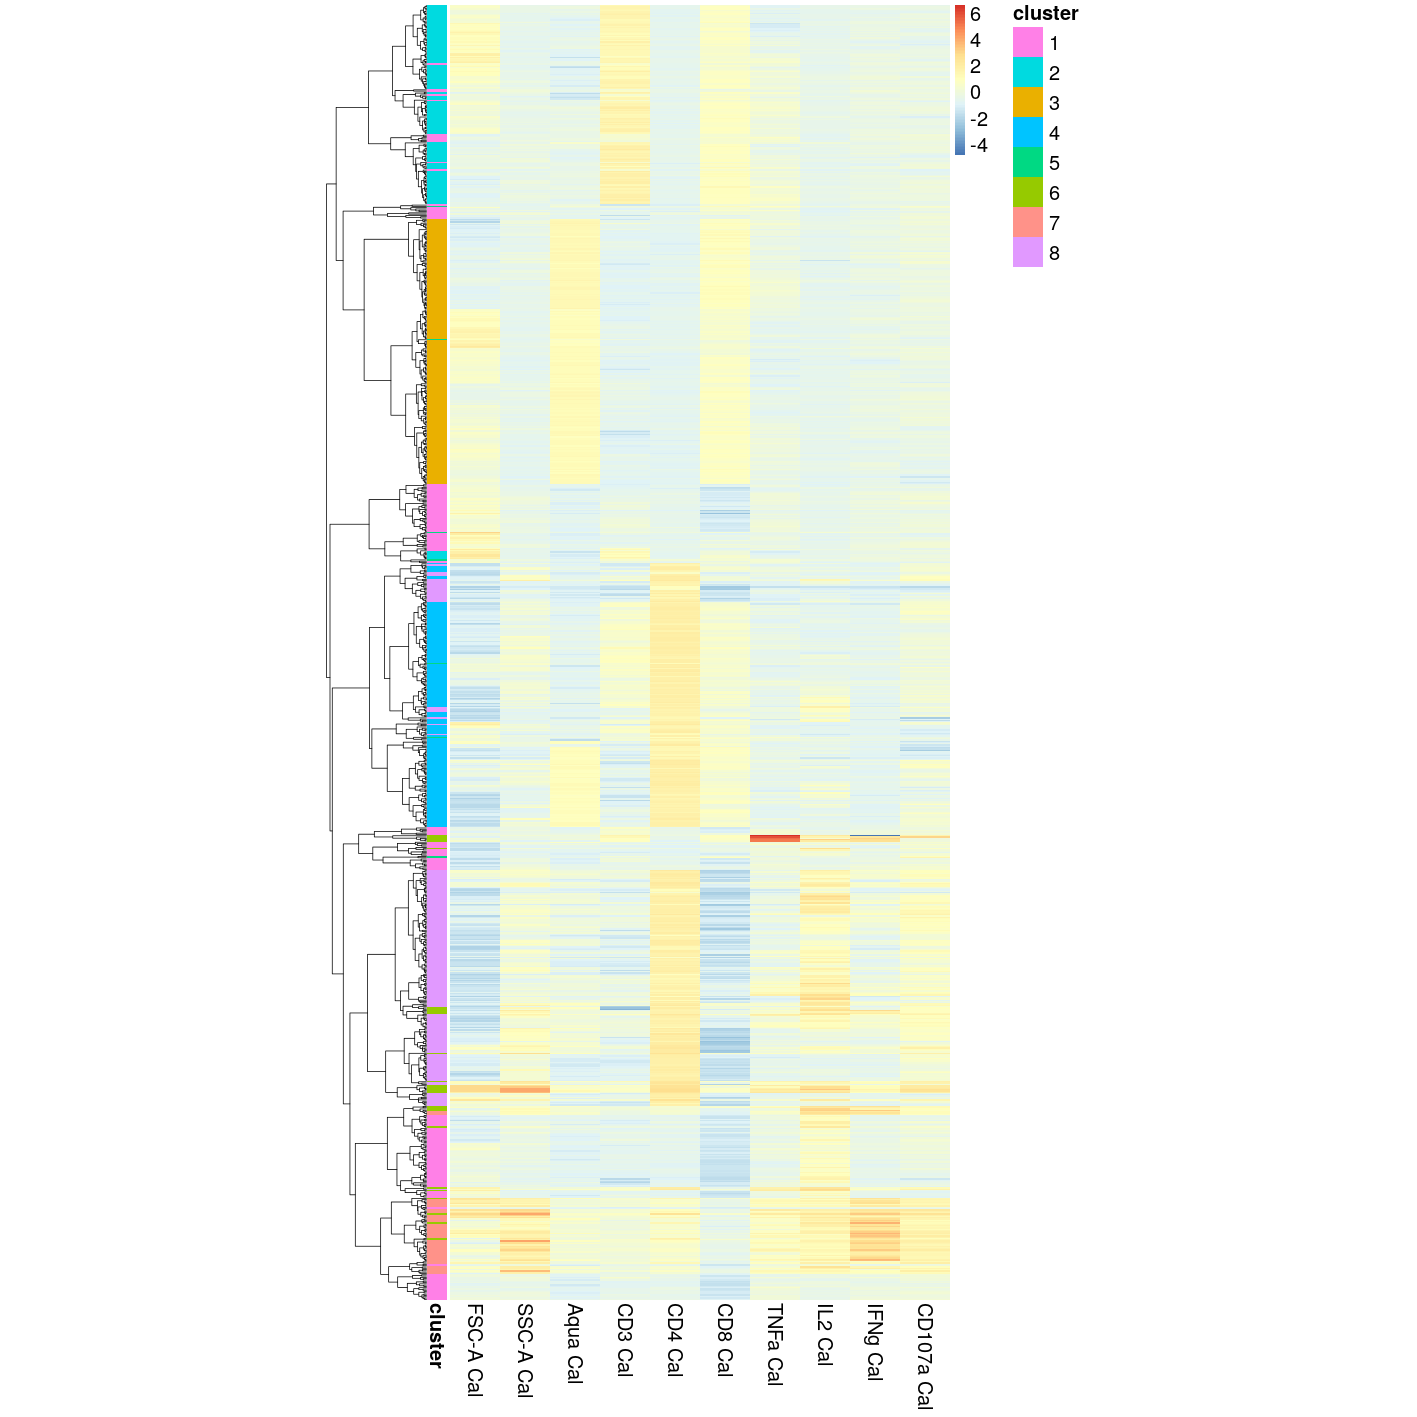

In [106]:
%%R -w 50 -h 50 -u cm
dat = dat_mpsk_cal
dat$cluster = as.integer(dat$cluster)
dat$cluster[dat$cluster==10] = 5L
dat$cluster[dat$cluster==9 ] = 7L

dat_sub = dat %>% dplyr::filter(sample == 1) 
mat     = dat_sub %>% dplyr::select(-sample, -cluster)
rownames(mat) = paste("Cell", rownames(mat))

df_annot_row = data.frame(cluster = as.character(dat_sub$cluster))
rownames(df_annot_row) = rownames(mat)

pheatmap(mat, 
         annotation_row = df_annot_row,
         #annotation_colors = brewer.pal(8, "Set3"),
         clustering_distance_rows = "correlation",
         cluster_cols   = FALSE, 
         fontsize = 20,
         show_rownames = FALSE,
         cellwidth = 50,
         width = 50,
         treeheight_row = 100)

In [134]:
%%R
create_frame = function(dat, idx_sample, df_annot){
    ###
    mat = dat %>% 
        dplyr::filter(sample == idx_sample) %>% 
        dplyr::select(-sample, -cluster) %>% 
        as.matrix
    
    ###
    tmp = apply(mat, 2, function(x){
        x_min   = min(x)
        x_max   = max(x)
        x_range = x_max - x_min
        res = c(x_range, x_min, x_max)
        names(res) = c("range", "minRange", "maxRange")
        return(res)
    })   
    tmp = tmp %>% t %>% as.data.frame

    ###
    df_annot  = data.frame(name = colnames(mat), desc = markers)
    df_annot = bind_cols(df_annot, tmp)  
    rownames(df_annot) = df_annot$name
    df_annot = Biobase::AnnotatedDataFrame(df_annot)

    ###
    frame = flowFrame(exprs = mat, parameters = df_annot)
    identifier(frame) = paste("Sample", idx_sample)

    return(frame)
} # end function

In [135]:
%%R
df  = data.frame(name = markers_label, desc = markers)
set = lapply(1:18, function(idx){
    create_frame(dat_mpsk, idx, df)
})
names(set) = sapply(set, identifier)

set = flowSet(set)
show(set)

#########################################################################
df  = data.frame(name = markers_label, desc = markers)
set_cal = lapply(1:18, function(idx){
    create_frame(dat_mpsk_cal, idx, df)
})
names(set_cal) = sapply(set_cal, identifier)

set_cal = flowSet(set_cal)
show(set_cal)

A flowSet with 18 experiments.

  column names:
  FSC-A SSC-A Aqua CD3 CD4 CD8 TNFa IL2 IFNg CD107a
A flowSet with 18 experiments.

  column names:
  FSC-A Cal SSC-A Cal Aqua Cal CD3 Cal CD4 Cal CD8 Cal TNFa Cal IL2 Cal IFNg Cal CD107a Cal


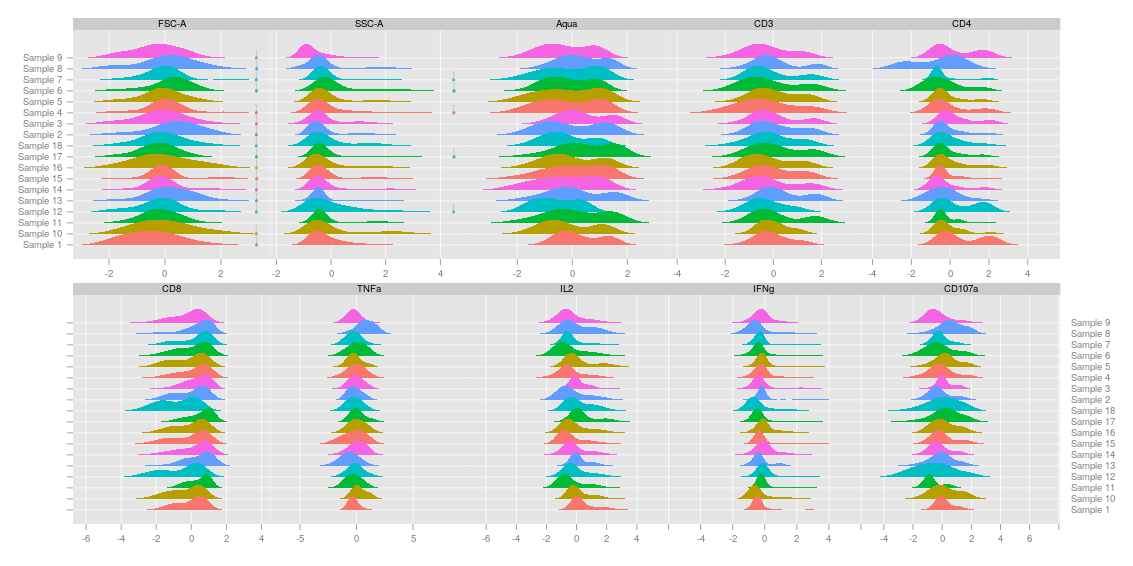

In [136]:
%%R -w 40 -h 20 -u cm
densityplot(~., set, channels = markers_label)

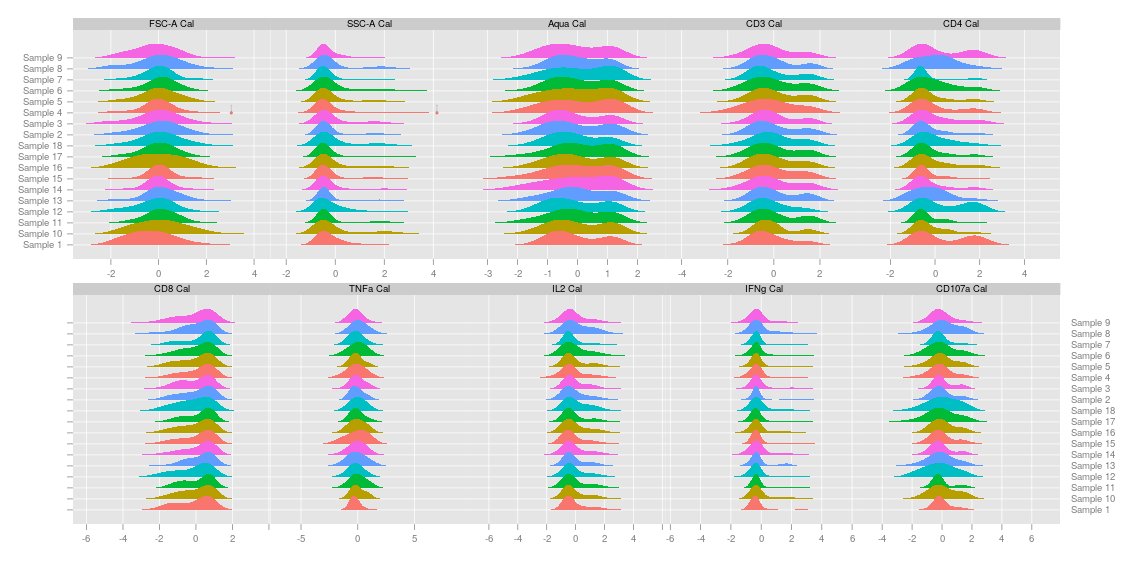

In [137]:
%%R -w 40 -h 20 -u cm
densityplot(~., set_cal, channels = markers_label)

# Compared MPSK calibration and Per-channel basis calibration

In [138]:
%%R
#df = data.frame(name = markers_label, desc = markers)
tmp = apply(mat, 2, function(x){
    x_min   = min(x)
    x_max   = max(x)
    x_range = x_max - x_min
    res = c(x_range, x_min, x_max)
    names(res) = c("range", "minRange", "maxRange")
    return(res)
}) %>% t
tmp

          range   minRange maxRange
FSC-A  5.290413 -2.3345064 2.955907
SSC-A  5.336420 -1.1627926 4.173627
Aqua   3.135670 -1.4240615 1.711609
CD3    4.941903 -3.0623618 1.879541
CD4    3.993868 -0.7739506 3.219918
CD8    3.658573 -2.4581361 1.200437
TNFa   8.350007 -1.6265138 6.723493
IL2    4.844126 -1.2407239 3.603402
IFNg   8.823920 -4.7940869 4.029833
CD107a 5.301652 -2.2414896 3.060163


In [139]:
%%R
idx = 1
dat = dat_mpsk
mat = dat %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample, -cluster) %>% as.matrix

tmp = apply(mat, 2, function(x){
    x_min   = min(x)
    x_max   = max(x)
    x_range = x_max - x_min
    res = c(x_range, x_min, x_max)
    names(res) = c("range", "minRange", "maxRange")
    return(res)
})
tmp = tmp %>% t %>% as.data.frame

df = data.frame(name = markers_label, desc = markers)
df = bind_cols(df, tmp)
rownames(df) = markers_label
df_annot = Biobase::AnnotatedDataFrame(df)

frame = flowFrame(exprs = mat, parameters = df_annot)
identifier(frame) = paste("Sample", idx)

frame

flowFrame object 'Sample 1'
with 1000 cells and 10 observables:
         name                 desc    range   minRange maxRange
FSC-A   FSC-A                FSC-A 5.290413 -2.3345064 2.955907
SSC-A   SSC-A                SSC-A 5.336420 -1.1627926 4.173627
Aqua     Aqua     Aqua Amine FLR-A 3.135670 -1.4240615 1.711609
CD3       CD3     CD3 APC-H7 FLR-A 4.941903 -3.0623618 1.879541
CD4       CD4     CD4 PE-Cy7 FLR-A 3.993868 -0.7739506 3.219918
CD8       CD8 CD8 PerCP-Cy55 FLR-A 3.658573 -2.4581361 1.200437
TNFa     TNFa      TNFa FITC FLR-A 8.350007 -1.6265138 6.723493
IL2       IL2      IL2 BV421 FLR-A 4.844126 -1.2407239 3.603402
IFNg     IFNg       IFNg APC FLR-A 8.823920 -4.7940869 4.029833
CD107a CD107a      CD107a PE FLR-A 5.301652 -2.2414896 3.060163
1 keywords are stored in the 'description' slot


In [140]:
%%R
df = data.frame(name = markers_label, desc = markers)
df = bind_cols(df, tmp)
rownames(df) = df$name
df

         name                 desc    range   minRange maxRange
FSC-A   FSC-A                FSC-A 5.290413 -2.3345064 2.955907
SSC-A   SSC-A                SSC-A 5.336420 -1.1627926 4.173627
Aqua     Aqua     Aqua Amine FLR-A 3.135670 -1.4240615 1.711609
CD3       CD3     CD3 APC-H7 FLR-A 4.941903 -3.0623618 1.879541
CD4       CD4     CD4 PE-Cy7 FLR-A 3.993868 -0.7739506 3.219918
CD8       CD8 CD8 PerCP-Cy55 FLR-A 3.658573 -2.4581361 1.200437
TNFa     TNFa      TNFa FITC FLR-A 8.350007 -1.6265138 6.723493
IL2       IL2      IL2 BV421 FLR-A 4.844126 -1.2407239 3.603402
IFNg     IFNg       IFNg APC FLR-A 8.823920 -4.7940869 4.029833
CD107a CD107a      CD107a PE FLR-A 5.301652 -2.2414896 3.060163


In [141]:
%%R
set_norm = gaussNorm(set, channel.names = markers_label)


Adjusting the distance between landmarks
..................


In [142]:
%%R
names(set_norm)

[1] "flowset"    "confidence"


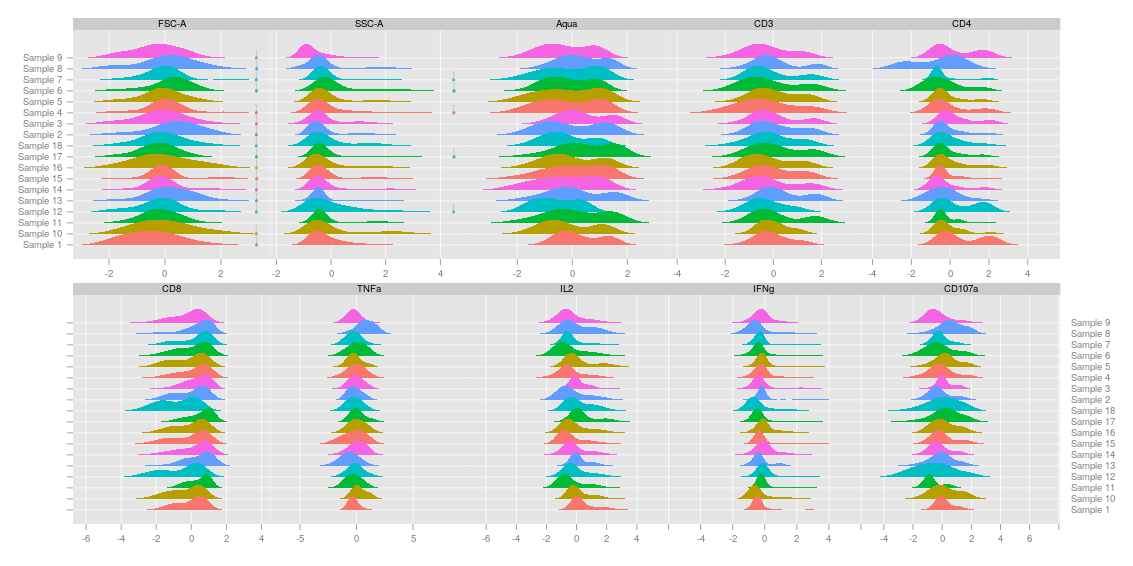

In [143]:
%%R -w 40 -h 20 -u cm
densityplot(~., set, channels = markers_label)

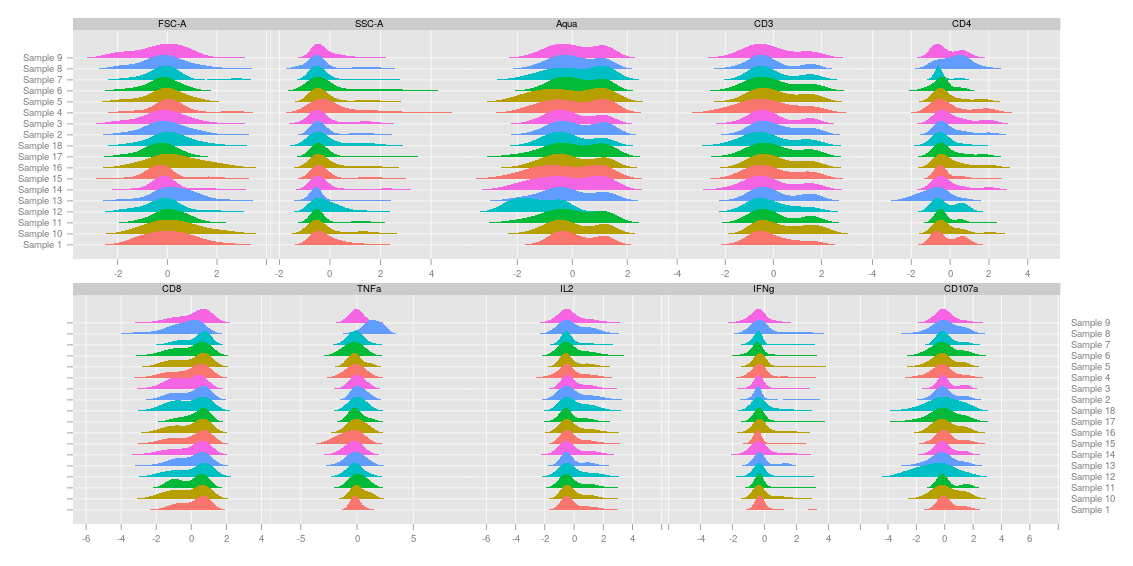

In [144]:
%%R -w 40 -h 20 -u cm
densityplot(~., set_norm$flowset, channels = markers_label)

# t-SNE

In [145]:
%%R
dat = dat_mpsk
mat = dat %>% dplyr::select(-sample, -cluster) %>% as.matrix
res_tsne_raw = tsne(mat[1:2000,], k = 2, perplexity = 30)
#dim(mat)

/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: sigma summary: Min. : 0.313412166867022 |1st Qu. : 0.426496489898294 |Median : 0.474448497533219 |Mean : 0.482517299189434 |3rd Qu. : 0.526094811773983 |Max. : 1.04202129007619 |

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #100 error is: 15.025404293144

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #200 error is: 1.12158258628051

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #300 error is: 0.952869887244009

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #400 error is: 0.88

In [146]:
%%R
dat = dat_mpsk_cal
mat = dat %>% dplyr::select(-sample, -cluster) %>% as.matrix
res_tsne_cal = tsne(mat[1:2000,], k = 2, perplexity = 30)
#dim(mat)

/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: sigma summary: Min. : 0.288548945506022 |1st Qu. : 0.407865236052879 |Median : 0.466504788928774 |Mean : 0.472779097988539 |3rd Qu. : 0.524005742204331 |Max. : 1.04134863291652 |

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #100 error is: 14.8262736114486

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #200 error is: 1.12155262690974

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #300 error is: 0.957368278096538

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #400 error is: 0.8

In [147]:
%%R
mat = lapply(1:length(set_norm$flowset), function(idx){
    frame = set_norm$flowset[[idx]]
    mat   = exprs(frame)
    return(mat)
}) # end lapply

mat = do.call(rbind, mat)
print(dim(mat))
res_tsne_gaussnorm = tsne(mat[1:2000,], k = 2, perplexity = 30)

/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: sigma summary: Min. : 0.282342713765565 |1st Qu. : 0.40648668724928 |Median : 0.460084272380402 |Mean : 0.470911849335063 |3rd Qu. : 0.517509766275337 |Max. : 1.01061806906295 |

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #100 error is: 15.6115164906818

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #200 error is: 1.1775834797695

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #300 error is: 1.00467402233044

  warnings.warn(x, RRuntimeWarning)
/local_data/env-py3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Epoch: Iteration #400 error is: 0.9359

[1] 18000    10


In [150]:
%%R
dim(res_tsne_raw) %>% print
dim(res_tsne_cal) %>% print
dim(res_tsne_gaussnorm) %>% print
clust %>% length

[1] 2000    2
[1] 2000    2
[1] 2000    2
[1] 1000


In [149]:
%%R
opar <- par()
opar

$xlog
[1] FALSE

$ylog
[1] FALSE

$adj
[1] 0.5

$ann
[1] TRUE

$ask
[1] FALSE

$bg
[1] "white"

$bty
[1] "o"

$cex
[1] 1

$cex.axis
[1] 1

$cex.lab
[1] 1

$cex.main
[1] 1.2

$cex.sub
[1] 1

$cin
[1] 0.15 0.20

$col
[1] "black"

$col.axis
[1] "black"

$col.lab
[1] "black"

$col.main
[1] "black"

$col.sub
[1] "black"

$cra
[1] 10.8 14.4

$crt
[1] 0

$csi
[1] 0.2

$cxy
[1] 0.02764128 0.04143646

$din
[1] 6.666667 6.666667

$err
[1] 0

$family
[1] ""

$fg
[1] "black"

$fig
[1] 0 1 0 1

$fin
[1] 6.666667 6.666667

$font
[1] 1

$font.axis
[1] 1

$font.lab
[1] 1

$font.main
[1] 2

$font.sub
[1] 1

$lab
[1] 5 5 7

$las
[1] 0

$lend
[1] "round"

$lheight
[1] 1

$ljoin
[1] "round"

$lmitre
[1] 10

$lty
[1] "solid"

$lwd
[1] 1

$mai
[1] 1.02 0.82 0.82 0.42

$mar
[1] 5.1 4.1 4.1 2.1

$mex
[1] 1

$mfcol
[1] 1 1

$mfg
[1] 1 1 1 1

$mfrow
[1] 1 1

$mgp
[1] 3 1 0

$mkh
[1] 0.001

$new
[1] FALSE

$oma
[1] 0 0 0 0

$omd
[1] 0 1 0 1

$omi
[1] 0 0 0 0

$page
[1] TRUE

$pch
[1] 1

$pin
[1] 5.426667 4.82666

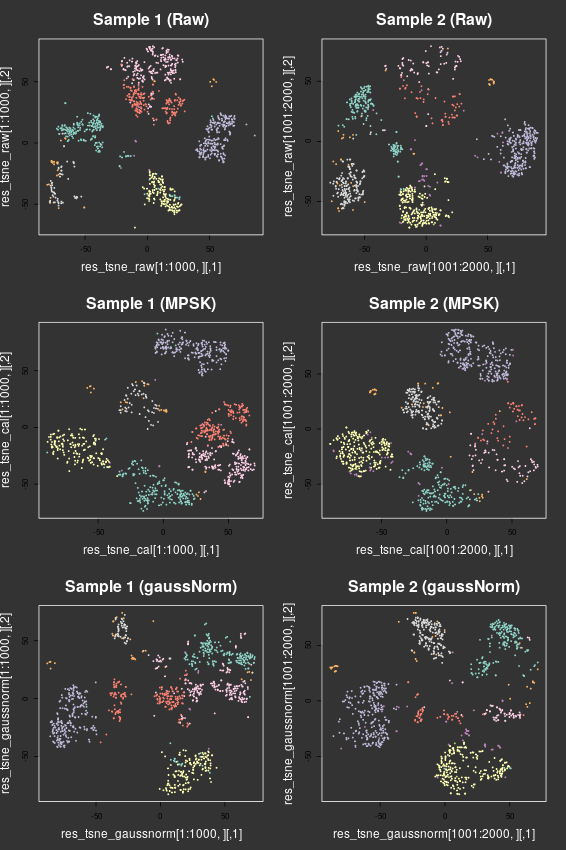

In [152]:
%%R -w 20 -h 30 -u cm
my_col = brewer.pal(10, "Set3")
par(mfrow=c(3, 2), bg="grey20", col="white", 
    col.main="white", col.lab="white", 
    cex.main=2,       cex.lab=1.5)

clust1 = dat_mpsk$cluster[   1:1000]
clust2 = dat_mpsk$cluster[1001:2000]
plot(res_tsne_raw[   1:1000,], pch = 20, cex = 0.5, col = my_col[clust1], main = "Sample 1 (Raw)")
plot(res_tsne_raw[1001:2000,], pch = 20, cex = 0.5, col = my_col[clust2], main = "Sample 2 (Raw)")
plot(res_tsne_cal[   1:1000,], pch = 20, cex = 0.5, col = my_col[clust1], main = "Sample 1 (MPSK)")
plot(res_tsne_cal[1001:2000,], pch = 20, cex = 0.5, col = my_col[clust2], main = "Sample 2 (MPSK)")
plot(res_tsne_gaussnorm[   1:1000,], pch = 20, cex = 0.5, col = my_col[clust1], main = "Sample 1 (gaussNorm)")
plot(res_tsne_gaussnorm[1001:2000,], pch = 20, cex = 0.5, col = my_col[clust2], main = "Sample 2 (gaussNorm)")

par(opar)